##### The Encoder-decoder goal is to build a candle classification dictionary for futher LLM
It encodes and decodes <b>normalized candles</b> as there is no goal yet to reproduce price move direction/distance or even correct candle height.
This is next step to be implemented with LLM-kind of model, where <i>candles will be considered as alphabet characters</i> and series of candles are words, sentences and chapters for price action poeme :-) 

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path



In [393]:
#Import NQ futures candles dataset
dataset = './data/nqh23_15sec.csv'
tick_data = './data/NQ 06-23.Last.csv'
if os.path.isfile(dataset):
    df1 = pd.read_csv(dataset)

else:
    header = ('date','last')
    df = pd.read_csv(tick_data, delimiter=';', usecols=[0,1], header=None, names=header)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d %H%M%S %f', utc = True)
    df1 = df.resample("15s", on = 'date',).ohlc()['last']
    df1.dropna(inplace=True)
    df1.to_csv(dataset)


df1.set_index('date',inplace=True)
df1.index.name = None
display(df1.head())
print(f"Candle dataset shape: {df1.shape}")


,open,high,low,close
2023-03-13 04:00:00+00:00,12177.25,12179.00,12177.25,12179.00
2023-03-13 04:00:15+00:00,12179.00,12179.25,12179.00,12179.25
2023-03-13 04:00:30+00:00,12181.25,12181.25,12180.25,12180.75
2023-03-13 04:00:45+00:00,12179.50,12179.75,12179.25,12179.75
2023-03-13 04:01:00+00:00,12180.00,12181.75,12180.00,12180.50


Candle dataset shape: (354167, 4)


In [388]:
# My own Normalisation function. the only reason I use them is I can easie reproduce them in TradingView Pinescript, 
# while e.g Pytorch nn.instanceNorm1d, gives sllughtly different result. But technically there is no differece which one to use here.
def MinMaxNorm(x: torch.Tensor, dim = None):

    r'''MinMax Normalization function, normalize values in (0,1) range.

    dim - dimentions setting, 
    where None - for global normalization, 1 - for per instance normalizaton and 0 - per feature normalization'''

    if dim == None:
        return (x - x.min())/(x.max() - x.min())
    elif dim == 1:
        return torch.nan_to_num((x - x.min(dim).values.reshape(-1,1))/(x.max(dim).values - x.min(dim).values).reshape(-1,1),0)
        
    elif dim == 0:
        return (x - x.min(dim).values)/(x.max(dim).values - x.min(dim).values)
    

def StandardNorm(x: torch.Tensor, dim = None):

    r'''Standard Normalization function, normalize values in (0,1) range.

    dim - dimentions setting, 
    where None - for global normalization, 1 - for per instance normalizaton and 0 - per feature normalization'''

    if dim == None:
        return (x - x.mean())/(x.std())
    elif dim ==1:
        return (x - x.mean(dim).reshape(-1,1))/(x.std(dim).reshape(-1,1))
    else:
        return (x - x.mean(dim))/(x.std(dim))



In [391]:
#Try to use torch Normalization function.

norm = nn.InstanceNorm1d(4)

features_enc = norm(torch.tensor(df1.iloc[:3,:4].values, dtype=torch.float))
features_enc


tensor([[-1.0000,  1.0000, -1.0000,  1.0000],
        [-1.0000,  1.0000, -1.0000,  1.0000],
        [ 0.9062,  0.9062, -1.5059, -0.3008]])

In [394]:
# Enc-Dec NN model definition. This is rather simple Linear with one hidden layer and Softmax activation 
# to get candles class codes (set of 10 candle features probabilities)
# Trained Encoder half of the model can be used later on for quick canldes classification.
# self.label is out put of the ecoder, which is indeed a candle class code

class CandleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
       
    #encoding layers
        self.seq1 = nn.Sequential(
            nn.Linear(4,64),
            #nn.ReLU(),
            nn.Linear(64,10),
            nn.Softmax(1)
        )
    #decoding layers    
        self.seq2 = nn.Sequential(
            nn.Linear(10,64),
            #nn.ReLU(),
            nn.Linear(64,4)
        )

    def forward(self, x):
        self.label = self.seq1(x)
        return self.seq2(self.label)


In [395]:
# in addition to Loss control< good to use a candle decode accuracyEncode-Decode accuracy calculation function

def accuracy(actual:torch.Tensor, pred:torch.Tensor, precision):
    return (torch.isclose(actual, pred, precision, precision).sum().item()/ (pred.shape[0] * pred.shape[1]))


In [418]:
#pick 10K candles as traning sample and conver to torch tensor

candles_sample = torch.tensor(df1.iloc[0:10000].values,dtype=torch.float)
candles_sample


tensor([[12177.2500, 12179.0000, 12177.2500, 12179.0000],
        [12179.0000, 12179.2500, 12179.0000, 12179.2500],
        [12181.2500, 12181.2500, 12180.2500, 12180.7500],
        ...,
        [12313.7500, 12314.0000, 12313.2500, 12313.2500],
        [12313.2500, 12315.0000, 12313.2500, 12314.2500],
        [12314.7500, 12315.5000, 12314.5000, 12315.5000]])

In [419]:
#normalize traning set of candles as encode-decode sample

candles_norm = MinMaxNorm(candles_sample, 1)



Epoch: 0 | Loss: 0.4136854112148285 | Accuracy: 0.01%
Epoch: 10000 | Loss: 3.1182446491584415e-06 | Accuracy: 63.84%
Epoch: 20000 | Loss: 1.6797738453533384e-06 | Accuracy: 71.83%
Epoch: 30000 | Loss: 1.5237640127452323e-06 | Accuracy: 77.68%
Epoch: 40000 | Loss: 1.806311047403142e-05 | Accuracy: 50.00%
Epoch: 50000 | Loss: 1.407533886776946e-06 | Accuracy: 79.25%
Epoch: 60000 | Loss: 8.922091865315451e-07 | Accuracy: 84.45%
Epoch: 70000 | Loss: 8.312344107253011e-06 | Accuracy: 51.83%
Epoch: 80000 | Loss: 4.6696570166204765e-07 | Accuracy: 91.09%
Epoch: 90000 | Loss: 1.4620174226820382e-07 | Accuracy: 97.71%

Epoch: 93479 | Loss: 1.4433967976401618e-07 | Accuracy: 99.15%


Text(0.5, 1.0, 'Traning accuracy')

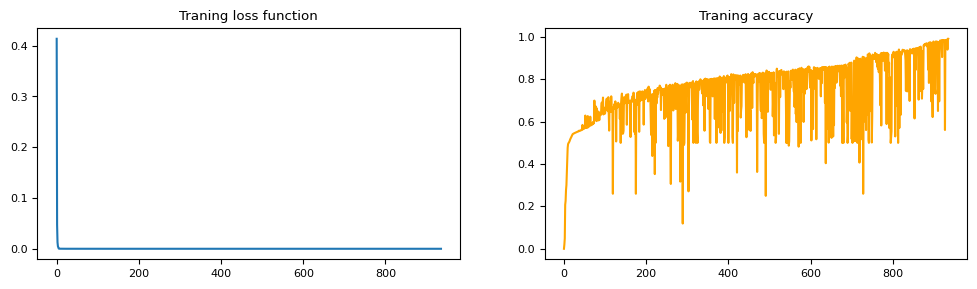

In [420]:
#Encode-Decode Traning loop

torch.manual_seed(42)
epochs = 100000
loss_plt = []
acc_plt = []
model0 = CandleClassifier()
model0 = model0.to("cpu")
candles_norm = candles_norm.to('cpu')
loss_fn =  nn.MSELoss()
optimizer = torch.optim.Adam(model0.parameters(), lr = 0.001) # Adam optimizer was choosen insted of SGD due convergency issues with SGD

      
for epoch in range(epochs):

    #set train mode
    model0.train()

    #forward pass
    out = model0(candles_norm)
    
    #loss and accuracy calculation
    loss = loss_fn(out, candles_norm)
    acc = accuracy(out, candles_norm, 1e-3)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #calculate and collect loss and accucary values through the traning fot further plot and print
    if epoch % 100 == 0:
        loss_plt.append(loss.item())
        acc_plt.append(acc)
    if epoch % (epochs/10) == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: %.2f" % (acc*100)+"%")
    #Break the traning loop in case the accuracy 99% is achieved    
    if acc > 0.99:
        break
#adding final Loss and accucacy    
loss_plt.append(loss.item())
acc_plt.append(acc)
print(f"\nEpoch: {epoch} | Loss: {loss} | Accuracy: %.2f" % (acc*100)+"%")

#Plot loss function and accuracy change through the traning
plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(loss_plt)
plt.title('Traning loss function')

plt.subplot(122)
plt.plot(acc_plt, color='orange')
plt.title('Traning accuracy')

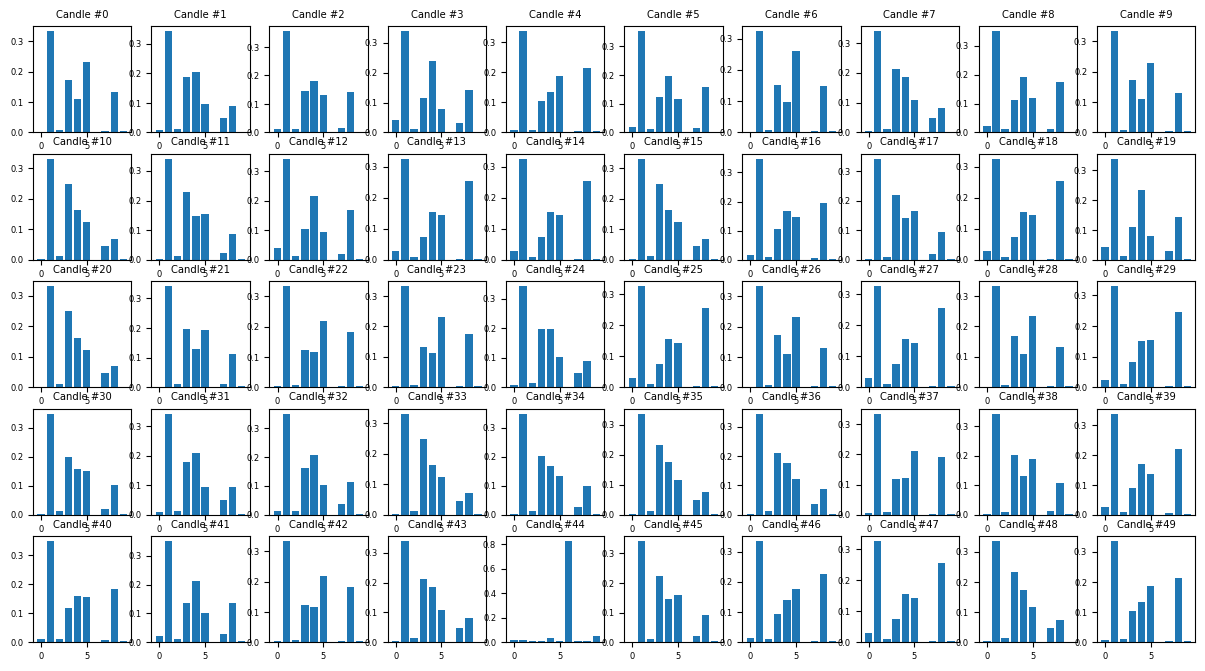

In [426]:
#plot example of 50 candles labels(classes) (kind of candle class code. )
#These candles are plotted in the next notebook cell

plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 6})
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.title(f'Candle #{i}')
    x = torch.tensor(list(enumerate(model0.label[5000+i].detach().numpy())))[:,0]
    y = torch.tensor(list(enumerate(model0.label[5000+i].detach().numpy())))[:,1]
    plt.bar(x,y)


In [422]:
##Function to plot candles from the dataset generated based on prediction
def plot_sample(sample):
    import plotly.graph_objects as go

    cdl_data = pd.DataFrame(sample, columns=('open','high','low','close') )

    fig = go.Figure(data=[go.Candlestick(x=cdl_data.index,
                    open=cdl_data['open'], high=cdl_data['high'],
                    low=cdl_data['low'], close=cdl_data['close'])
                        ])

    # fig.add_trace(
    #     go.Scatter(
    #         x=cdl_data.index,
    #         y=cdl_data['high'],
    #         mode= "text",
            
    #         text = cdl_data['class'],
    #         textposition = 'top center',
    #         textfont = {'size':8}))

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

In [423]:
#plot normalized candles chart along with original candles, to compare if each candle has the same style (color, body height, ratio or shift)

plot_sample(out[5000:5050].detach().numpy())
plot_sample(candles_sample[5000:5050].detach().numpy())

In [441]:
#Plot the same candle chart for a validation set. Note that traning set was only 10K candles our of 350K in full dataset.
#Below we try to use rest of 340K candles as validation and check it accuracy ;-). Traning set accuracy was 99%

candles_validate = torch.tensor(df1.iloc[10000:].values,dtype=torch.float)
candles_validate_norm = MinMaxNorm(candles_validate,dim=1)

with torch.inference_mode():
    out_validate = model0(candles_validate_norm)
    print(f'Validation set accuracy: {accuracy(out_validate,candles_validate_norm,1e-3)*100 :.2f}%')

plot_sample(out_validate[1000:1050].detach().numpy())
plot_sample(candles_validate[1000:1050].detach().numpy())


Validation set accuracy: 97.85%
